In [1]:
#!pip install pandas matplotlib lifelines forestplot scikit-survival
import pandas as pd
import lifelines
df = lifelines.datasets.load_gbsg2()
df["Event"] = ~df.cens.astype(bool) # 形成事件是1/True，删失为0/False的数据列
display(df, df.describe())

# 某些情况需要拼合数据如下注释
# from sksurv.datasets import load_veterans_lung_cancer
# data_x, data_y = load_veterans_lung_cancer() # 导入示例数据
# df = pd.concat([data_x, pd.DataFrame(data_y)], axis=1) #组成常见的数据集合形态
# #df.dropna(subset="Survival_in_days", inplace=True) #无时长事件采取删除处理
# display(df, df.Status.unique()) #查看数据形态与事件删失指示列是否仅为二分类
# # 其中
# # Survival_in_days可以认为是OS/PFS这类时长性终点指标
# # Status True 认为是事件event, False/Nan认为是删失
# # Treatment 认为是治疗分组


,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens,Event
0,no,70,Post,21,II,3,48,66,1814,1,False
1,yes,56,Post,12,II,7,61,77,2018,1,False
2,yes,58,Post,35,II,9,52,271,712,1,False
3,yes,59,Post,17,II,4,60,29,1807,1,False
4,no,73,Post,35,II,1,26,65,772,1,False
...,...,...,...,...,...,...,...,...,...,...,...
681,no,49,Pre,30,III,3,1,84,721,0,True
682,yes,53,Post,25,III,17,0,0,186,0,True
683,no,51,Pre,25,III,5,43,0,769,1,False
684,no,52,Post,23,II,3,15,34,727,1,False


,age,tsize,pnodes,progrec,estrec,time,cens
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,53.052478,29.329446,5.010204,109.995627,96.252187,1124.489796,0.435860
std,10.120739,14.296217,5.475483,202.331552,153.083963,642.791948,0.496231
min,21.000000,3.000000,1.000000,0.000000,0.000000,8.000000,0.000000
25%,46.000000,20.000000,1.000000,7.000000,8.000000,567.750000,0.000000
50%,53.000000,25.000000,3.000000,32.500000,36.000000,1084.000000,0.000000
75%,61.000000,35.000000,7.000000,131.750000,114.000000,1684.750000,1.000000
max,80.000000,120.000000,51.000000,2380.000000,1144.000000,2659.000000,1.000000


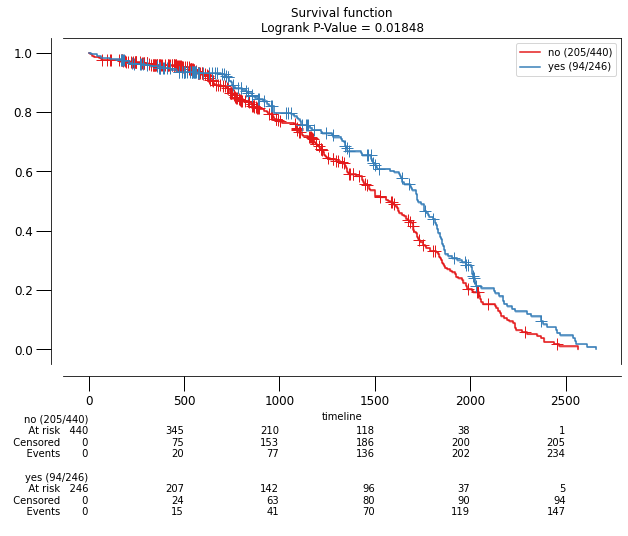

In [2]:
# KM曲线绘制的第一种形式(简单化）
import kaplanmeier as km
km.plot(km.fit(df["time"], df["Event"], df["horTh"]), cii_lines='dense', cii_alpha=0.05) # cii是有的只是太小看不太出来

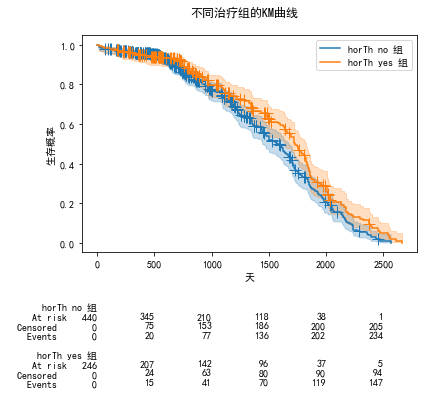

In [3]:
# KM曲线绘制的第二种形式(可定制化）
from lifelines import KaplanMeierFitter as KMF
from lifelines.plotting import add_at_risk_counts
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def plot_km_curve(data, treatment_key, survival_length_key, event_key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    kmf_l = []
    for tr_gr in df[treatment_key].unique():
        kmf = KMF()
        c = (data[treatment_key]==tr_gr)
        ax = kmf.fit(durations=data[c][survival_length_key], event_observed=data[c][event_key], label=treatment_key+" "+str(tr_gr)+" 组")\
            .plot_survival_function(ax=ax, show_censors=True)
        kmf_l.append(kmf)
    fig.suptitle("不同治疗组的KM曲线")
    ax.set_ylabel("生存概率")
    ax.set_xlabel("天")
    add_at_risk_counts(*kmf_l, ax=ax)
    return ax

tmt_k = "horTh"
sv_len_k = "time"
ev_k = "Event"
nax = plot_km_curve(df, tmt_k, sv_len_k, ev_k)

<Axes: xlabel='<-- PFS longer [Hazard Ratio] PFS shorter-->', ylabel='Confidence interval'>

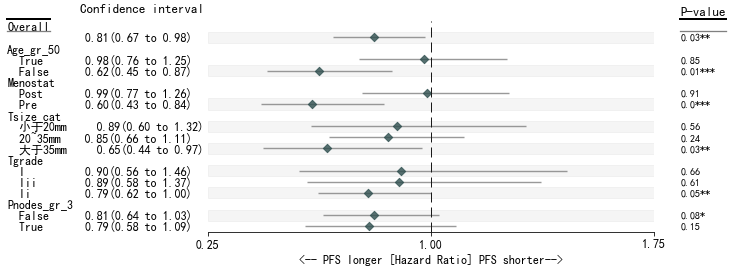

In [5]:
#Cox’s proportional hazard model 拟合亚组subgroup分析绘制森林图
from lifelines import CoxPHFitter
import forestplot as fp
mpl.rcParams['font.monospace'] = ['SimHei']

# 暂时无法对连续变量进行分析，以下结合数据分布进行人为分类
df["Age_gr_50"] = df["age"]>50
df["tsize_cat"] = "小于20mm"
df.loc[df["tsize"]>=35, "tsize_cat"] = "大于35mm"
df.loc[(df["tsize"]<35) & (df["tsize"]>=20), "tsize_cat"] = "20~35mm"
df["pnodes_gr_3"] = df["pnodes"]>3

# 治疗组仅支持两两比较，并需要转换为bool类
df["treat"] = False
df.loc[df["horTh"]=="yes","treat"]=True

def get_cox_summary(data, group_name, var_name, survival_length_key, event_key):
    cph = CoxPHFitter(penalizer=0.1)
    rdf = cph.fit(data, duration_col=survival_length_key, event_col=event_key).summary
    rdf["group_name"]=str(group_name)
    rdf["var_name"]=str(var_name)
    rdf["range"] = rdf[["exp(coef) lower 95%","exp(coef) upper 95%"]].values.tolist()
    return rdf

# 已知治疗、对照组，对以每分类循环以每个对照组为基线算出治疗组该分类的harzard ratio然后再组合展示（默认过滤掉了对照组基线hazards ratio==1的数据）
def calculate_hazards_ratio(data, overall_name, variant_list, treatment_key, survival_length_key, event_key):
    l = []  
    # 总体
    dataj = data[[survival_length_key,event_key]].join(data[treatment_key])
    l.append(get_cox_summary(dataj, overall_name, " ", survival_length_key, event_key))
    # 各分类
    for var in variant_list:
        datad = data.dropna(subset=var) # 这里采用了丢弃的方式处理nan值，可以根据需要利用if-eles等判断自行更改
        if datad.empty:
            print(f"{var}值下无非空数据")
        else:
            for v in datad[var].unique():
                dataf = datad[datad[var] == v].copy()
                if dataf[treatment_key].nunique()==2:
                    dataj = dataf[[survival_length_key,event_key]].join(dataf[treatment_key])
                    l.append(get_cox_summary(dataj, var, v, survival_length_key, event_key))
                else:
                    print(f"{var} {v} 分类无法按治疗/控制组二分类分层分析予跳过")
    return pd.concat(l)
    
vars = ["Age_gr_50", "menostat","tsize_cat","tgrade","pnodes_gr_3"] #,"progrec"
ov_na = "Overall"
tmt_k = "treat"
sv_len_k = "time"
ev_k = "Event"

c = calculate_hazards_ratio(df, ov_na, vars, tmt_k, sv_len_k, ev_k)

fp.forestplot(c.reset_index(), 
              estimate="exp(coef)",  # col containing estimated effect size 
              ll="exp(coef) lower 95%", 
              hl="exp(coef) upper 95%",  # columns containing conf. int. lower and higher limits
              groupvar="group_name", 
              group_order=[ov_na]+vars, # 此处Overall名称要与上方函数对应
              varlabel="var_name",
              capitalize="capitalize",
              table=True, 
              sort=True,
              color_alt_rows=True,
              pval="p",
              ylabel="Confidence interval",  # y-label title
              xlabel="<-- PFS longer [Hazard Ratio] PFS shorter-->",  # x-label title
              xticks=[0.25,1,1.75],
              xline=1,
              **{"figsize":(8,4),
                 "marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": ".1",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                }
              )

<Axes: xlabel='<-- PFS longer [Hazard Ratio] PFS shorter-->', ylabel='Confidence interval'>

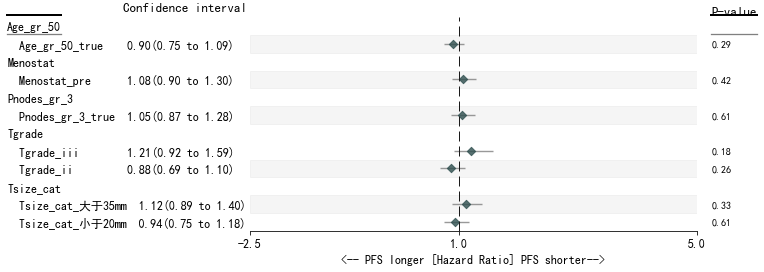

In [9]:
# 如果未知分组（如尚未揭盲），则直接对分组内不同类进行比较（即将其中一类设为hazards ratio==1, 然后看其他类是比它大还是小）
mpl.rcParams['font.monospace'] = ['SimHei']

def calculate_hazards_ratio_as(data, variant_list, survival_length_key, event_key):
    l = []
    for var in variant_list:
        datavd = pd.get_dummies(data[var].fillna(method='bfill'),prefix=var, drop_first=True)
        dataj = data[[survival_length_key,event_key]].join(datavd)
        cph = CoxPHFitter(penalizer=0.1)
        rdf = cph.fit(dataj, duration_col=survival_length_key, event_col=event_key).summary  #, show_progress=True
        rdf["group"]=var
        rdf["range"] = rdf[["exp(coef) lower 95%","exp(coef) upper 95%"]].values.tolist()
        l.append(rdf)
    return pd.concat(l)

vars = ["Age_gr_50", "menostat","tsize_cat","tgrade","pnodes_gr_3"]
sv_len_k = "time"
ev_k = "Event"

c = calculate_hazards_ratio_as(df, vars, sv_len_k, ev_k)

fp.forestplot(c.reset_index(), 
              estimate="exp(coef)",  # col containing estimated effect size 
              ll="exp(coef) lower 95%", 
              hl="exp(coef) upper 95%",  # columns containing conf. int. lower and higher limits
              varlabel="covariate",  # column containing variable label
              capitalize="capitalize", 
              groupvar="group", 
              ylabel="Confidence interval",  # y-label title
              xlabel="<-- PFS longer [Hazard Ratio] PFS shorter-->",  # x-label title
              xticks=[-2.5,1, 5],
              xline=1,
              pval="p",
              color_alt_rows=True,
              sort=True,
              table=True,               
              **{"figsize":(8,4),
                 "marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": ".1",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                }
              )

# ----------------多分组还可以看下面的示例----------------
# https://nbviewer.org/github/LSYS/forestplot/blob/main/examples/readme-examples.ipynb
# https://nbviewer.org/github/LSYS/forestplot/blob/mplot-dev/examples/test-multmodel-sleep.ipynb